## Mount Drive & Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install opendatasets
!pip install chart_studio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 64 kB 2.3 MB/s 
  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11447 sha256=ca0d06e611b06d89755c68c475ccfa614ad4d2109a18f59f88078a7c908fb6e5
  Stored in directory: /root/.cache/pip/wheels/f9/8d/8d/f6af3f7f9eea3553bc2fe6d53e4b287dad18b06a861ac56ddf
Successfully built retrying


In [ ]:
import opendatasets as od
from google.colab import drive

import cv2
import imutils
import numpy as np
import pandas as pd

import seaborn as sns
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from plotly.offline import iplot
from wordcloud import WordCloud

from PIL import Image
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from wordcloud import WordCloud, STOPWORDS

import plotly.express as px
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot
import cufflinks
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

In [ ]:
#filepath = '/content/drive/My Drive/ML/Data/Handwriting/' #On Drive 
filepath = '/content/drive/My Drive/MSCA_ML/Final_Project/Data/Handwriting/'
#df_train = pd.read_csv(filepath + 'df_train_with_bb.csv')

### Loading Image

In [ ]:
od.download("https://www.kaggle.com/datasets/landlord/handwriting-recognition/download")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: xuetingggg
Your Kaggle Key: ··········


100%|██████████| 1.26G/1.26G [00:06<00:00, 200MB/s]


In [ ]:
file_path_train = '/content/handwriting-recognition/train_v2/train/'
file_path_test = '/content/handwriting-recognition/test_v2/test/'
file_path_valid = '/content/handwriting-recognition/validation_v2/validation/'

In [ ]:
train = pd.read_csv(filepath + 'train.csv')
valid = pd.read_csv(filepath + 'valid.csv')

### Image Shape EDA

In [ ]:
img_filepath = file_path_train

In [ ]:
image_shapes = []
for p in range(len(train)):
    image = cv2.imread(img_filepath + train.iloc[p].FILENAME)
    temp_shape = image.shape
    image_shapes.append(temp_shape)

In [ ]:
df_shape = pd.DataFrame(image_shapes)

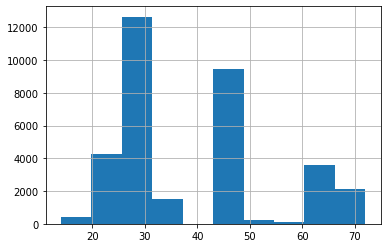

In [ ]:
df_shape[0].hist()

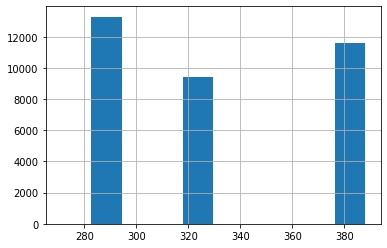

In [ ]:
df_shape[1].hist()

In [ ]:
df_shape.columns = ['height', 'width', 'dim']

In [ ]:
#df_shape.to_csv(filepath + 'df_shape.csv')

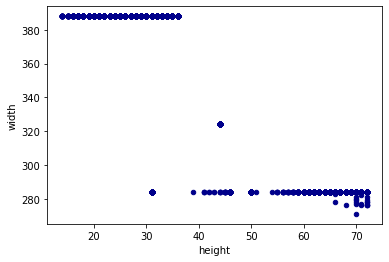

In [ ]:
ax1 = df_shape.plot.scatter(x='height', y='width', c='DarkBlue')

In [ ]:
train_n_shape = train.merge(df_shape, how='inner', left_index=True, right_index = True)

In [ ]:
train_n_shape.head()

,FILENAME,IDENTITY,height,width,dim
0,TRAIN_00006.jpg,lucie,31,284,3
1,TRAIN_00011.jpg,emma,44,324,3
2,TRAIN_00020.jpg,romain,44,324,3
3,TRAIN_00027.jpg,thomas,44,324,3
4,TRAIN_00069.jpg,ines,23,388,3


### Clustering with KMeans

#### Helper Function get_avg_image

In [ ]:
#Given the filename list, output length and output width, outputs the average image of that name
def get_avg_image(file_list, img_w, img_h):
  
  avg_img = np.zeros((img_h,img_w),float) #Avg image for each name, initialied

  for i in range(len(file_list)):
    name_dir = file_path_train+file_list[i]
    name_img = cv2.imread(name_dir, cv2.IMREAD_GRAYSCALE)
    img_reshape = cv2.resize(name_img, dsize=(img_w, img_h))
    avg_img += img_reshape #accumulator for each name 
    
  avg_img = avg_img/len(file_list)
  return avg_img

Text(0, 0.5, 'WCSS')

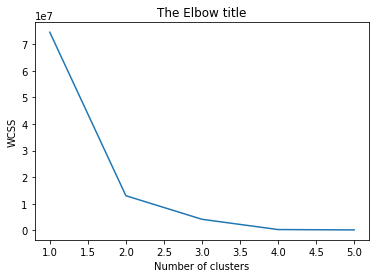

In [ ]:
from sklearn.cluster import KMeans

x = train_n_shape[['height', 'width']]
wcss=[]
for i in range(1,6):
  kmeans = KMeans(i)
  kmeans.fit(x)
  wcss_iter = kmeans.inertia_
  wcss.append(wcss_iter)

number_clusters = range(1,6)
plt.plot(number_clusters,wcss)
plt.title('The Elbow title')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

In [ ]:
kmeans = KMeans(4)
identified_clusters = kmeans.fit(x)

In [ ]:
identified_clusters.labels_

array([1, 2, 2, ..., 0, 0, 2], dtype=int32)

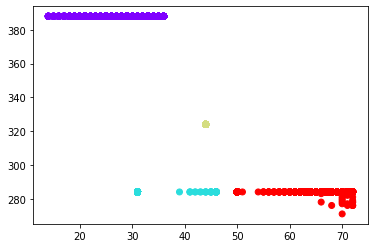

In [ ]:
plt.scatter(train_n_shape['height'],train_n_shape['width'],c=identified_clusters.labels_,cmap='rainbow')

In [ ]:
train_n_shape['km_cluster'] = identified_clusters.labels_

In [ ]:
kmeans_cluster_avg = [] #accumulator of image for each cluster
for n in range(len(set(identified_clusters.labels_))):
  temp_cluster = np.array(train_n_shape[train_n_shape['km_cluster'] == n].FILENAME)
  temp_max_h = max(train_n_shape[train_n_shape['km_cluster'] == n].height)
  temp_max_w = max(train_n_shape[train_n_shape['km_cluster'] == n].width)
  avg = get_avg_image(temp_cluster, temp_max_w, temp_max_h)
  kmeans_cluster_avg.append(avg)

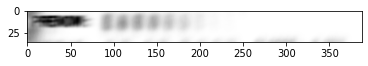

In [ ]:
plt.imshow(kmeans_cluster_avg[0], cmap = 'gray')

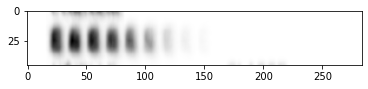

In [ ]:
plt.imshow(kmeans_cluster_avg[1], cmap = 'gray')

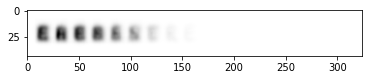

In [ ]:
plt.imshow(kmeans_cluster_avg[2], cmap = 'gray')

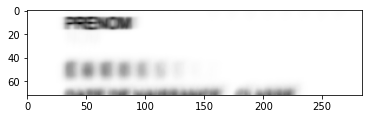

In [ ]:
plt.imshow(kmeans_cluster_avg[3], cmap = 'gray')

##### Boundary Testing

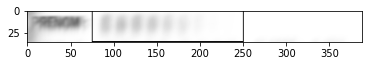

In [ ]:
img0 = kmeans_cluster_avg[0].copy()
cv2.rectangle(img0, (75, 0), (250, 35), (0,255,0),1) #Second tuple - left up (x, y); third tuple - right bottom (x, y)
plt.imshow(img0, cmap = 'gray')

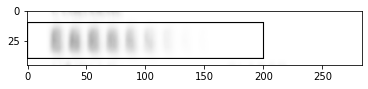

In [ ]:
img1 = kmeans_cluster_avg[1].copy()
cv2.rectangle(img1, (0, 10), (200, 40), (0,255,0),1) #Second tuple - left up (x, y); third tuple - right bottom (x, y)
plt.imshow(img1, cmap = 'gray')

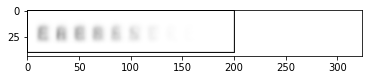

In [ ]:
img2 = kmeans_cluster_avg[2].copy()
cv2.rectangle(img2, (0, 0), (200, 40), (0,255,0),1) #Second tuple - left up (x, y); third tuple - right bottom (x, y)
plt.imshow(img2, cmap = 'gray')

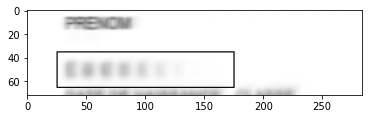

In [ ]:
img3 = kmeans_cluster_avg[3].copy()
cv2.rectangle(img3, (25, 35), (175, 65), (0,255,0),1) #Second tuple - left up (x, y); third tuple - right bottom (x, y)
plt.imshow(img3, cmap = 'gray')

In [ ]:
kmeans_boundary_list = [[(75, 0), (250, 35)], [(0, 10), (200, 40)], [(0, 0), (200, 40)], [(25, 35), (175, 65)]]

In [ ]:
kmeans_boundary_list

[[(75, 0), (250, 35)],
 [(0, 10), (200, 40)],
 [(0, 0), (200, 40)],
 [(25, 35), (175, 65)]]

### Cropping Images and Padding

From the average images we see that four classes of images from KMeans varies in image width and height, and each cluster have a common type of noise in the image. We preprocess our images accordingly.

#### By KMeans

In [ ]:
kmeans_boundary_list = [[(75, 0), (250, 35)], [(0, 10), (200, 40)], [(0, 0), (200, 40)], [(25, 35), (175, 65)]]

##### Image Cropping by KMeans

In [ ]:
total=[]
crop_boxes = []
for i in range(0,len(train)):
  img_dir =  file_path_train+train_n_shape.loc[i, 'FILENAME']
  srcImage = Image.open(img_dir)
  cluster = train_n_shape.loc[i, 'km_cluster']
  image_bx = srcImage.width
  image_by = srcImage.height
  bx = min(kmeans_boundary_list[cluster][1][0], image_bx) 
  by = min(kmeans_boundary_list[cluster][1][1], image_by) #Take image boundary if crop boundary larger than size
  crop_box =  kmeans_boundary_list[cluster][0] + (bx, by)
  crop_boxes.append(crop_box)
  srcImage = srcImage.crop(crop_box)
  srcImage = srcImage.resize((200,35))
  grayImage = srcImage.convert('L')
  binarizedImage = grayImage.point(lambda x: 0 if x<200 else 1, '1')
  pixel = list(binarizedImage.getdata())
  total.append(pixel)

In [ ]:
df_kmeans_cropped = pd.DataFrame(total)

In [ ]:
df_kmeans_cropped['IDENTITY'] = train_n_shape.IDENTITY

In [ ]:
#train_n_shape.to_csv(filepath + 'train_n_shape.csv')
df_kmeans_cropped.to_csv(filepath + 'df_kmeans_cropped.csv')